### Test the processImage pipeline on a single image

In [19]:
TEST_IMAGE_PATH = "test_images/challenge3.png"
import os
imgs = os.listdir("test_images/")
imgs = ["test_images/" + x for x in  imgs ]
IMAGES = [TEST_IMAGE_PATH, "all"]
IMAGES = IMAGES + imgs

hyperParamsDefault = {
    "blurKernalSize": (5,1,29,2),  # (value, min, max, step)
    "cannyHT": (300,0,500,10),
    "cannyLT": (50,0,500,10),
    "bThresh": (200,0,255,1),
    "hThresh": (10,0,100,1),
    "hMinLineLen": (20,0,100,1),
    "hMaxLineGap": (1.0,0.0,40.0,0.1),
    "useBrightness": (True),
    "images": IMAGES,
    "outputStage": ["final", "final", "gray", "blur", "canny", "hsv", "hue", "saturation", "brightness", "bMask", "hough"]
}

print(IMAGES)

['test_images/challenge3.png', 'all', 'test_images/challenge1.png', 'test_images/challenge2.png', 'test_images/challenge3.png', 'test_images/solidWhiteCurve.jpg', 'test_images/solidWhiteRight.jpg', 'test_images/solidYellowCurve.jpg', 'test_images/solidYellowCurve2.jpg', 'test_images/solidYellowLeft.jpg', 'test_images/whiteCarLaneSwitch.jpg']


In [20]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import helpers
import ipywidgets as widgets
from ipywidgets import interact, interactive, fixed, interact_manual

%matplotlib inline  
%load_ext autoreload
%autoreload 2

from helpers import *
from lanedetector import detectLanes
from io import BytesIO
from base64 import b64encode
from PIL import Image
from IPython.core.display import display, HTML


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [21]:
# Disable Autoscrolling
from IPython.display import display, Javascript

disable_js = """
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}
"""

def load_ipython_extension(ip):
    display(Javascript(disable_js))
    print ("autoscrolling long output is disabled")

load_ipython_extension(0)

<IPython.core.display.Javascript object>

autoscrolling long output is disabled


In [22]:

def parseParams(hyParams):
    outP = {}
    for k in hyParams:
        try:
            outP[k] = hyParams[k][0]
        except:
            outP[k] = hyParams[k]
    return outP

def parseParamsInteract(hyParams):
    outP = {}
    for k in hyParams:
        try:
            outP[k] = (hyParams[k][1:])
        except:
            outP[k] = hyParams[k]
    return outP
        
hyperParams = parseParams(hyperParamsDefault)
hyperParamsInteract = parseParamsInteract(hyperParamsDefault)

In [23]:
# %load lanedetector.py
from helpers import *

def detectLanes(img, params):

    blkrSize = params["blurKernalSize"]
    cht = params["cannyHT"]
    clt = params["cannyLT"]
    stage = params["outputStage"]


    hsv = getHSV(img)

    bMask = hsv[:,:,2] > params.get("bThresh", 200)

    if params["useBrightness"]:
        # gray = hsv[:,:,2]
        gray = bMask.astype(np.uint8)*255
    else:
        gray = grayscale(img)

    blur = gaussian_blur(gray, kernel_size=blkrSize)
       
    ht = cht
    lt = clt
    canny_edges = canny(blur, low_threshold=lt, high_threshold=ht)

    #hsv = getHSV(img)
    bMask = cv2.bitwise_and(img, img, mask=bMask.astype(np.uint8))
    bMask = cv2.cvtColor(bMask, cv2.COLOR_BGR2RGB)


    rho = 1 # distance resolution in pixels of the Hough grid
    theta = np.pi/180 # angular resolution in radians of the Hough grid
    threshold = params.get("hThresh", 10)
    min_line_length = params.get("hMinLineLen", 20)
    max_line_gap = params.get("hMaxLineGap", 1)

    houghImg = hough_lines(canny_edges, rho, theta, threshold, min_line_length, max_line_gap)


    outpDict = {
            "final": houghImg,
            "blur": blur,
            "gray": gray,
            "canny": canny_edges,
            "hsv": hsv,
            "brightness": hsv[:,:,2],
            "hue": hsv[:,:,1],
            "saturation": hsv[:,:,0],
            "bMask": bMask,
            "hough": houghImg,

    }

    return outpDict[stage]


In [24]:
# InLine image display helpers

def getPngBytes(img):
    pil_im = Image.fromarray(img)
    b = BytesIO()  
    pil_im.save(b, format='png')
    return b.getvalue()
    
def displaySideBySide(im1, im2):
    
    im1 = cv2.cvtColor(im1, cv2.COLOR_BGR2RGB)
    b1 = getPngBytes(im1)
    b2 = getPngBytes(im2)
    b641 = b64encode(b1).decode('utf-8')
    b642 = b64encode(b2).decode('utf-8')
    HTMLDATA = "<table><tr><td><img src='data:image/png;base64,{0}'/></td><td><img src='data:image/png;base64,{1}'/></td></tr></table>".format(b641, b642)
    display(HTML(HTMLDATA))

{'blurKernalSize': 5, 'cannyHT': 300, 'cannyLT': 50, 'bThresh': 200, 'hThresh': 10, 'hMinLineLen': 20, 'hMaxLineGap': 1.0, 'useBrightness': False, 'images': 'test_images/challenge3.png', 'outputStage': 'hough'}


,

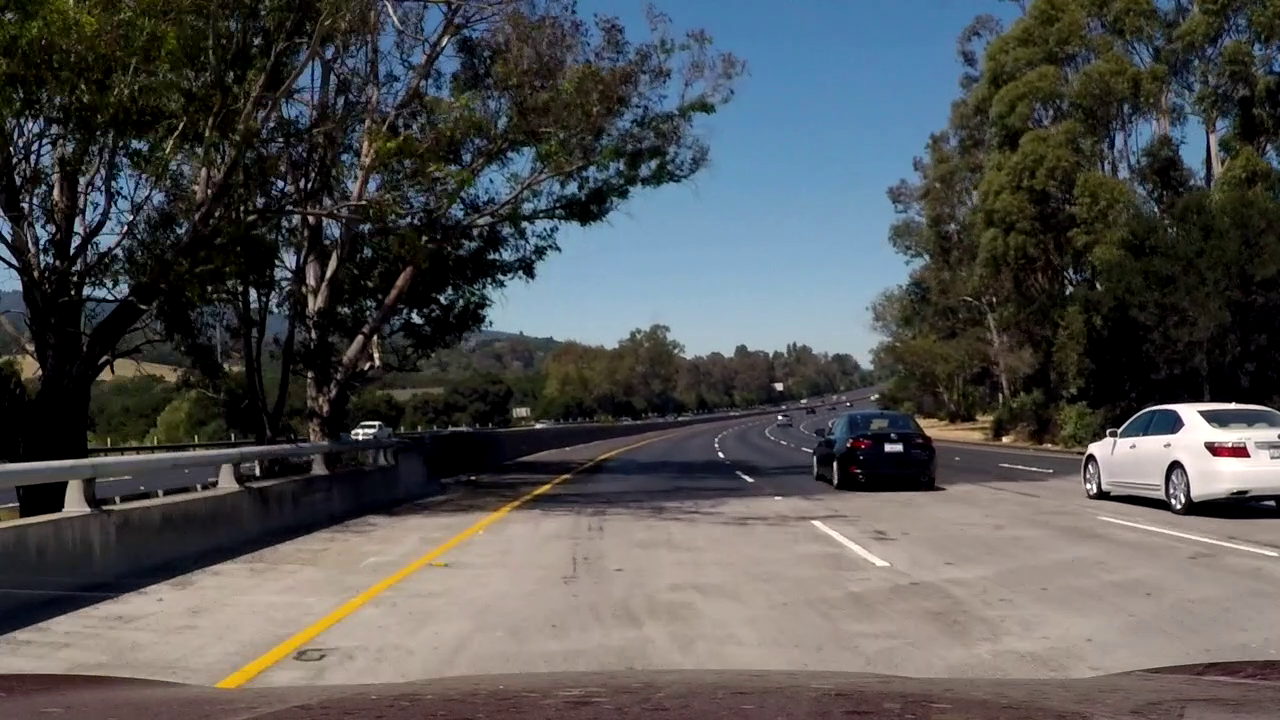
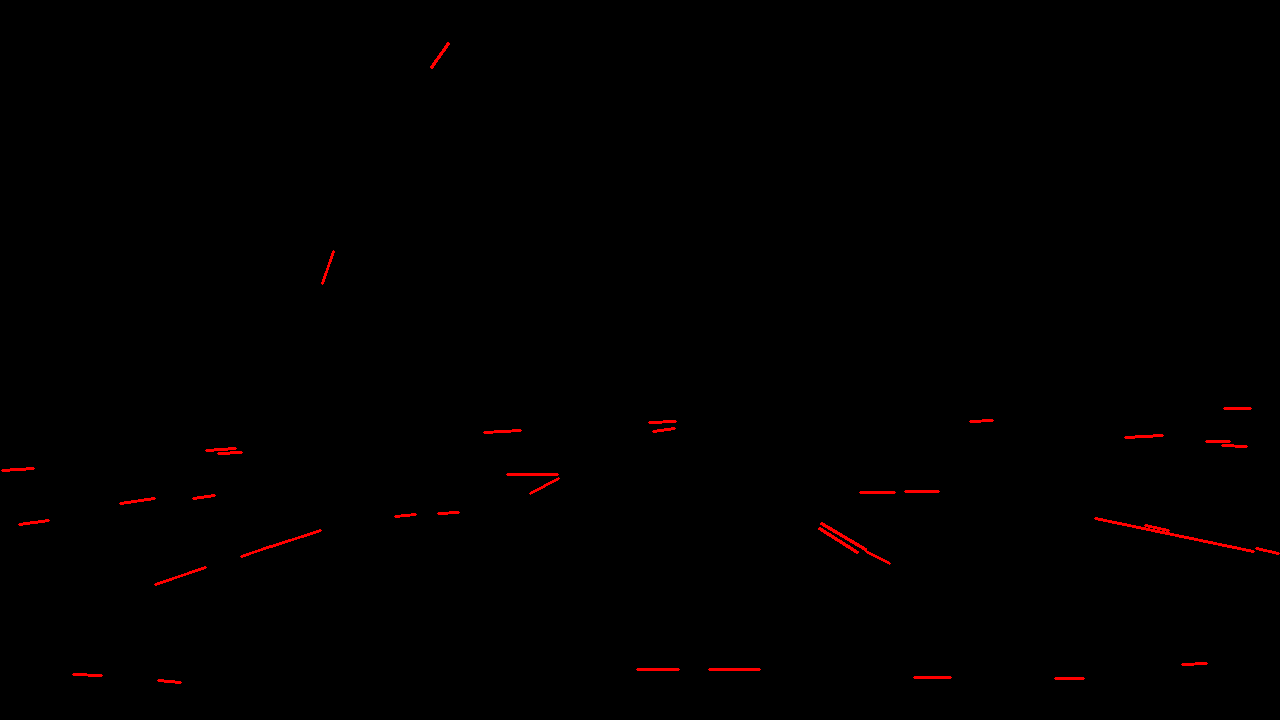

In [25]:
image = readImg(TEST_IMAGE_PATH)
hyperParams["outputStage"] = "hough"
hyperParams["useBrightness"] = False
print(hyperParams)
outP =(detectLanes(image, hyperParams))
displaySideBySide(image, outP)

In [26]:
# Interactive parameter tuning

PLAYED_PARAMS = {}

def assignDefaults(wids, defVal):
    valDict = {}
    for wid in wids.children:
        try:
            valDict[wid.description] = wid
        except:
            pass
    for k in valDict:
        try:
            valDict[k].value = defVal[k]
        except:
            pass

def processImgPath(imgPath, kwargs):
    image = readImg(imgPath)
    outP =(detectLanes(image, kwargs))
    displaySideBySide(image, outP)

def playWithParams(**kwargs):
    global PLAYED_PARAMS
    PLAYED_PARAMS = kwargs
    try:
        if kwargs["images"] == "all":
            for imgPath in IMAGES[2:]:
                processImgPath(imgPath, kwargs)
        else:
            processImgPath(kwargs["images"], kwargs)
            
    except:
        pass
        #print "EXCEPTION!", e
        #outP = image
    
w = interactive(playWithParams, **hyperParamsInteract)

import json
with open('params.json', 'r') as fp:
    global hyperParams
    try:
        hyperParams = json.load(fp)
    except:
        print("Failed loading params from params.json file!")
    
assignDefaults(w, hyperParams)
display(w)


interactive(children=(IntSlider(value=5, description='blurKernalSize', max=29, min=1, step=2), IntSlider(value=60, description='cannyHT', max=500, step=10), IntSlider(value=280, description='cannyLT', max=500, step=10), IntSlider(value=197, description='bThresh', max=255), IntSlider(value=11, description='hThresh'), IntSlider(value=20, description='hMinLineLen'), FloatSlider(value=10.0, description='hMaxLineGap', max=40.0), Checkbox(value=True, description='useBrightness'), Dropdown(description='images', index=3, options=('all', 'test_images/challenge1.png', 'test_images/challenge2.png', 'test_images/challenge3.png', 'test_images/solidWhiteCurve.jpg', 'test_images/solidWhiteRight.jpg', 'test_images/solidYellowCurve.jpg', 'test_images/solidYellowCurve2.jpg', 'test_images/solidYellowLeft.jpg', 'test_images/whiteCarLaneSwitch.jpg'), value='test_images/challenge3.png'), Dropdown(description='outputStage', options=('final', 'gray', 'blur', 'canny', 'hsv', 'hue', 'saturation', 'brightness', 'bMask', 'hough'), value='final'), Output()), _dom_classes=('widget-interact',))

In [27]:
import json

def saveParams():
    with open('params.json', 'w') as fp:
        json.dump(PLAYED_PARAMS, fp)
        
    print("Params saved to params.json!")
# Call this to save the params
saveParams()

Params saved to params.json!
